In [1]:
# Mateusz Chojnacki
# Kolokwium

In [2]:
# Wczytywanie bibliotek

In [3]:
# Pomaga przy błędzie na chmurze słów
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000

In [4]:
# !pip install contractions
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# !pip install textblob
# !pip install wordcloud

import pandas as pd
import numpy as np
import re
import string
import nltk
import contractions
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from string import digits
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
# Wczytywanie danych

In [6]:
df = pd.read_csv('tweets_airline.csv', sep=',');
df.reset_index(drop=True, inplace=True);
print(df)

                 tweet_id airline_sentiment  airline_sentiment_confidence  \
0      570306133677760513           neutral                        1.0000   
1      570301130888122368          positive                        0.3486   
2      570301083672813571           neutral                        0.6837   
3      570301031407624196          negative                        1.0000   
4      570300817074462722          negative                        1.0000   
...                   ...               ...                           ...   
14635  569587686496825344          positive                        0.3487   
14636  569587371693355008          negative                        1.0000   
14637  569587242672398336           neutral                        1.0000   
14638  569587188687634433          negative                        1.0000   
14639  569587140490866689           neutral                        0.6771   

               negativereason  negativereason_confidence         airline  \

In [7]:
# Dane składają się z 15 kolumn oraz 14640 wierszy

# Sprawdzenie czy nie ma brakujących danych

In [8]:
for col in df.columns:
    print(col, df[col].isnull().sum())

tweet_id 0
airline_sentiment 0
airline_sentiment_confidence 0
negativereason 5462
negativereason_confidence 4118
airline 0
airline_sentiment_gold 14600
name 0
negativereason_gold 14608
retweet_count 0
text 0
tweet_coord 13621
tweet_created 0
tweet_location 4733
user_timezone 4820


In [9]:
# W danych występują brakujące dane.
# W naszym zadaniu interesuje nas kolumna airline_sentiment oraz text.
# Jak widzimy w powyższych dwóch kolumnach nie występuje brak danych.

In [10]:
# Wybranie odpowidnich kolumn

In [11]:
rws = df.loc[:, ['airline_sentiment', 'text']];
print(rws)

      airline_sentiment                                               text
0               neutral                @VirginAmerica What @dhepburn said.
1              positive  @VirginAmerica plus you've added commercials t...
2               neutral  @VirginAmerica I didn't today... Must mean I n...
3              negative  @VirginAmerica it's really aggressive to blast...
4              negative  @VirginAmerica and it's a really big bad thing...
...                 ...                                                ...
14635          positive  @AmericanAir thank you we got on a different f...
14636          negative  @AmericanAir leaving over 20 minutes Late Flig...
14637           neutral  @AmericanAir Please bring American Airlines to...
14638          negative  @AmericanAir you have my money, you change my ...
14639           neutral  @AmericanAir we have 8 ppl so we need 2 know h...

[14640 rows x 2 columns]


In [12]:
# Czyszczenie tekstu

In [13]:
punc = string.punctuation;
stop_words = set(stopwords.words('english'));

# Angielskie skróty rozszerzone
rws['no_contract'] = rws['text'].apply(lambda x: [contractions.fix(word) for word in x.split()]);
rws['text_str'] = [' '.join(map(str, l)) for l in rws['no_contract']];

# Usuniete '...'
rws['...'] = rws['text_str'].apply(lambda x: [word.replace("...", "") for word in x.split()]);

# Usunięte html
rws['non_html'] = rws['...'].apply(lambda x: [re.sub(r'http\S+', '', word) for word in x]);

# Usunięcię słów @...
rws['non_html'] = rws['...'].apply(lambda x: [re.sub(r'@\S+', '', word) for word in x]);

# Usunięta interpunkcja
rws['non_dots'] = rws['non_html'].apply(lambda x: [re.sub(r"\b\d+\b", "", word) for word in x]);
rws['non_other'] = rws['non_dots'].apply(lambda x: [re.sub(r'[^\w]', ' ', word) for word in x]);

# Małe litery
rws['lower'] = rws['non_other'].apply(lambda x: [word.lower() for word in x]);

# Usunięcię interpunkcji
rws['no_punc'] = rws['lower'].apply(lambda x: [word for word in x if word not in punc]);

# Usunięcie StopWords
rws['stopwords_removed'] = rws['no_punc'].apply(lambda x: [word for word in x if word not in stop_words]);

# Usunięcie wszystkich innych specjalnych znaków
rws['final'] = rws['stopwords_removed'].apply(lambda x: [re.sub('[^A-Za-z0-9]+', '', word) for word in x]);

train_data = rws['final']
print(rws['final'])

0                                                   [said]
1            [plus, added, commercials, experience, tacky]
2           [today, must, mean, need, take, another, trip]
3        [really, aggressive, blast, obnoxious, enterta...
4                                [really, big, bad, thing]
                               ...                        
14635             [thank, got, different, flight, chicago]
14636    [leaving, minutes, late, flight, warnings, com...
14637    [please, bring, american, airlines, blackberry10]
14638    [money, change, flight, answer, phones, sugges...
14639    [people, need, know, many, seats, next, flight...
Name: final, Length: 14640, dtype: object


In [14]:
# Stemmeing

In [15]:
stemmer = SnowballStemmer("english")

rws['stemmed'] = rws['final'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
print(rws['stemmed'])

0                                                   [said]
1                      [plus, ad, commerci, experi, tacki]
2             [today, must, mean, need, take, anoth, trip]
3        [realli, aggress, blast, obnoxi, entertain, gu...
4                                [realli, big, bad, thing]
                               ...                        
14635                [thank, got, differ, flight, chicago]
14636    [leav, minut, late, flight, warn, communic, mi...
14637       [pleas, bring, american, airlin, blackberry10]
14638    [money, chang, flight, answer, phone, suggest,...
14639    [peopl, need, know, mani, seat, next, flight, ...
Name: stemmed, Length: 14640, dtype: object


In [16]:
# Lematyzacja

In [17]:
rws['pos_tags'] = rws['stemmed'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
rws['wordnet_pos'] = rws['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wnl = WordNetLemmatizer()
rws['lemmatized'] = rws['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
lemmatized = rws.lemmatized
print(lemmatized)

0                                                    [say]
1                      [plus, ad, commerci, experi, tacki]
2             [today, must, mean, need, take, anoth, trip]
3        [realli, aggress, blast, obnoxi, entertain, gu...
4                                [realli, big, bad, thing]
                               ...                        
14635                [thank, get, differ, flight, chicago]
14636    [leav, minut, late, flight, warn, communic, mi...
14637        [plea, bring, american, airlin, blackberry10]
14638    [money, chang, flight, answer, phone, suggest,...
14639    [peopl, need, know, mani, seat, next, flight, ...
Name: lemmatized, Length: 14640, dtype: object


In [18]:
# Wybieramy kolumny które nas interesują
# Kolumnę text wybieramy po oczyszczeniu oraz po stemmingu i lematyzacji
# Finalnie wybieramy kolumny airline_sentiment z naszą oceną oraz oczyszczony komenatrz tweeta czyli kolumna lemmatized. 
df = rws[['airline_sentiment', 'lemmatized']]
print(df)

      airline_sentiment                                         lemmatized
0               neutral                                              [say]
1              positive                [plus, ad, commerci, experi, tacki]
2               neutral       [today, must, mean, need, take, anoth, trip]
3              negative  [realli, aggress, blast, obnoxi, entertain, gu...
4              negative                          [realli, big, bad, thing]
...                 ...                                                ...
14635          positive              [thank, get, differ, flight, chicago]
14636          negative  [leav, minut, late, flight, warn, communic, mi...
14637           neutral      [plea, bring, american, airlin, blackberry10]
14638          negative  [money, chang, flight, answer, phone, suggest,...
14639           neutral  [peopl, need, know, mani, seat, next, flight, ...

[14640 rows x 2 columns]


In [19]:
# Analiza nastrojów
# gdzie : 1 : pozytywny, -1 : bardzo negatywny

In [20]:
df['lemma_str'] = [' '.join(map(str,l)) for l in df['lemmatized']]
# print(df)

df['sentiment'] = df['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_data = df.drop(columns = ['lemmatized', 'sentiment'])
print(df)

C:\Users\mateu\AppData\Local\Temp/ipykernel_13532/323960193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemma_str'] = [' '.join(map(str,l)) for l in df['lemmatized']]


      airline_sentiment                                         lemmatized  \
0               neutral                                              [say]   
1              positive                [plus, ad, commerci, experi, tacki]   
2               neutral       [today, must, mean, need, take, anoth, trip]   
3              negative  [realli, aggress, blast, obnoxi, entertain, gu...   
4              negative                          [realli, big, bad, thing]   
...                 ...                                                ...   
14635          positive              [thank, get, differ, flight, chicago]   
14636          negative  [leav, minut, late, flight, warn, communic, mi...   
14637           neutral      [plea, bring, american, airlin, blackberry10]   
14638          negative  [money, chang, flight, answer, phone, suggest,...   
14639           neutral  [peopl, need, know, mani, seat, next, flight, ...   

                                               lemma_str  senti

C:\Users\mateu\AppData\Local\Temp/ipykernel_13532/323960193.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [21]:
# Możemy zaobserowowac że przy Sentiment : negative zachodzi albo wartość 0 albo na minusie.
# Wg definichi im wyższa wartość do wartości 1 tym sentiment bardziej pozytywny.

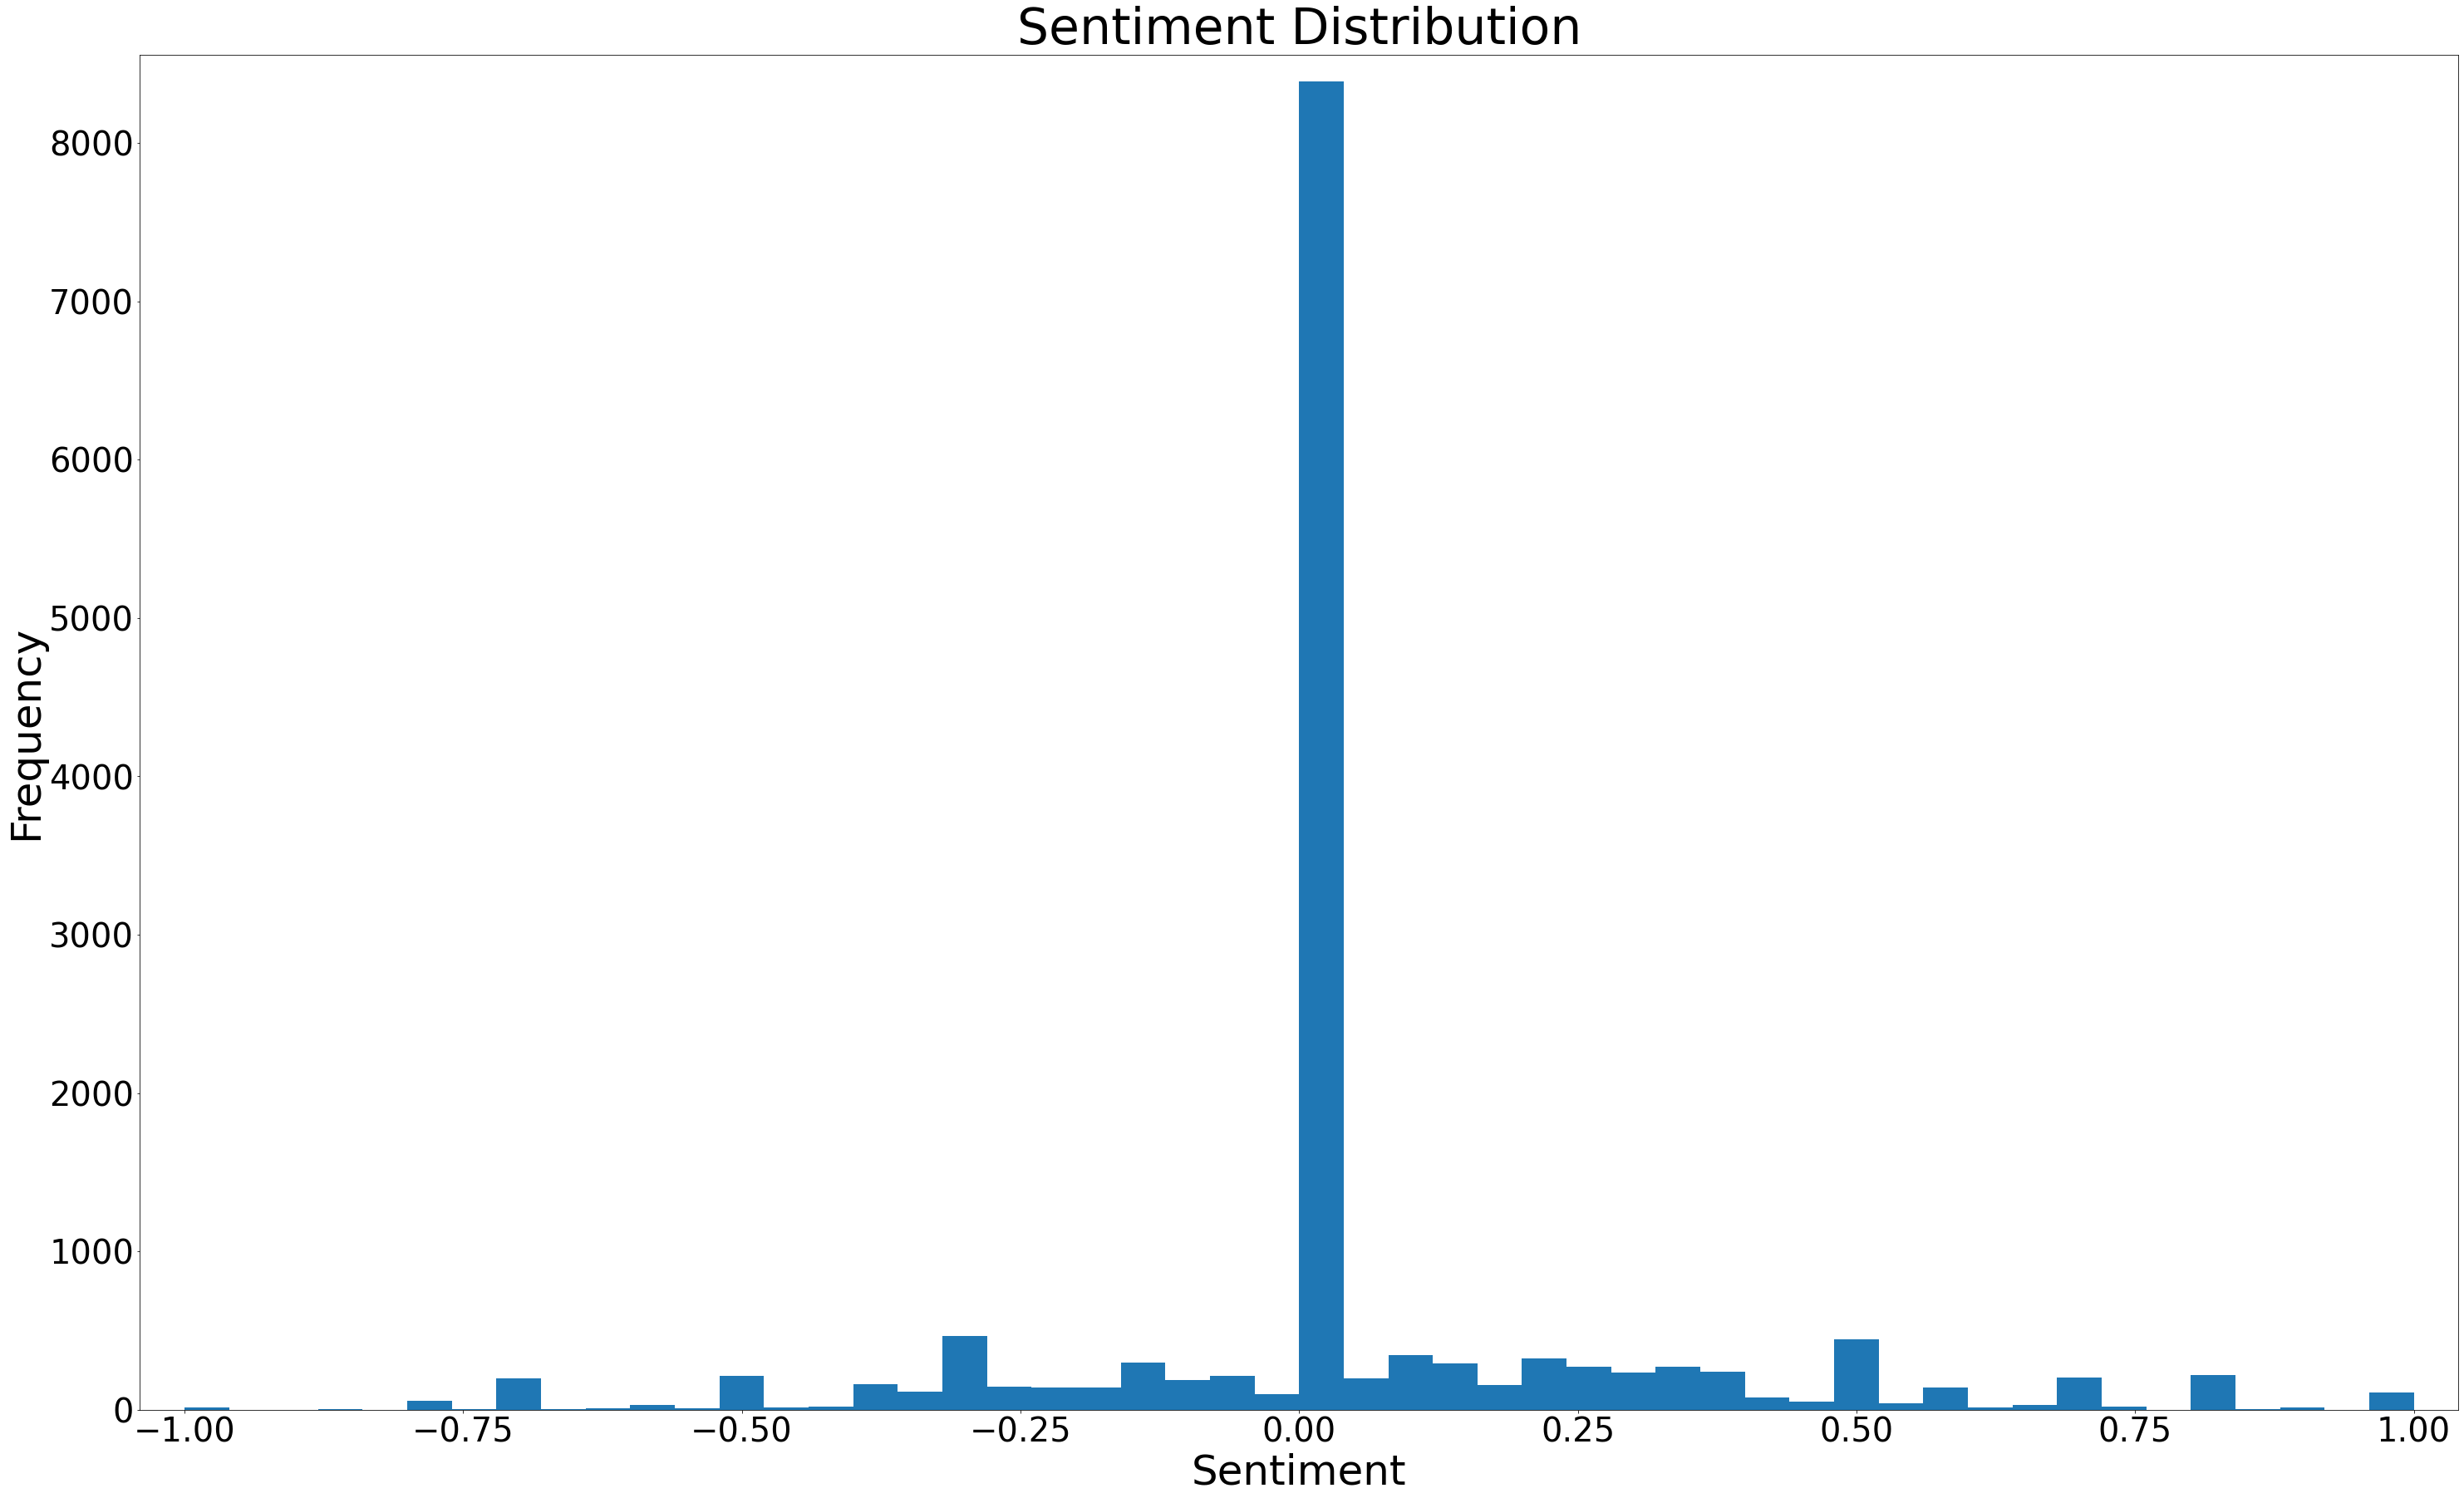

In [22]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

In [23]:
# Na powyższym wykresie widzimy że większość opini znajduje się w 0 wartości sentimentu dla podanych tweetow.

E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2]),
 [Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')])

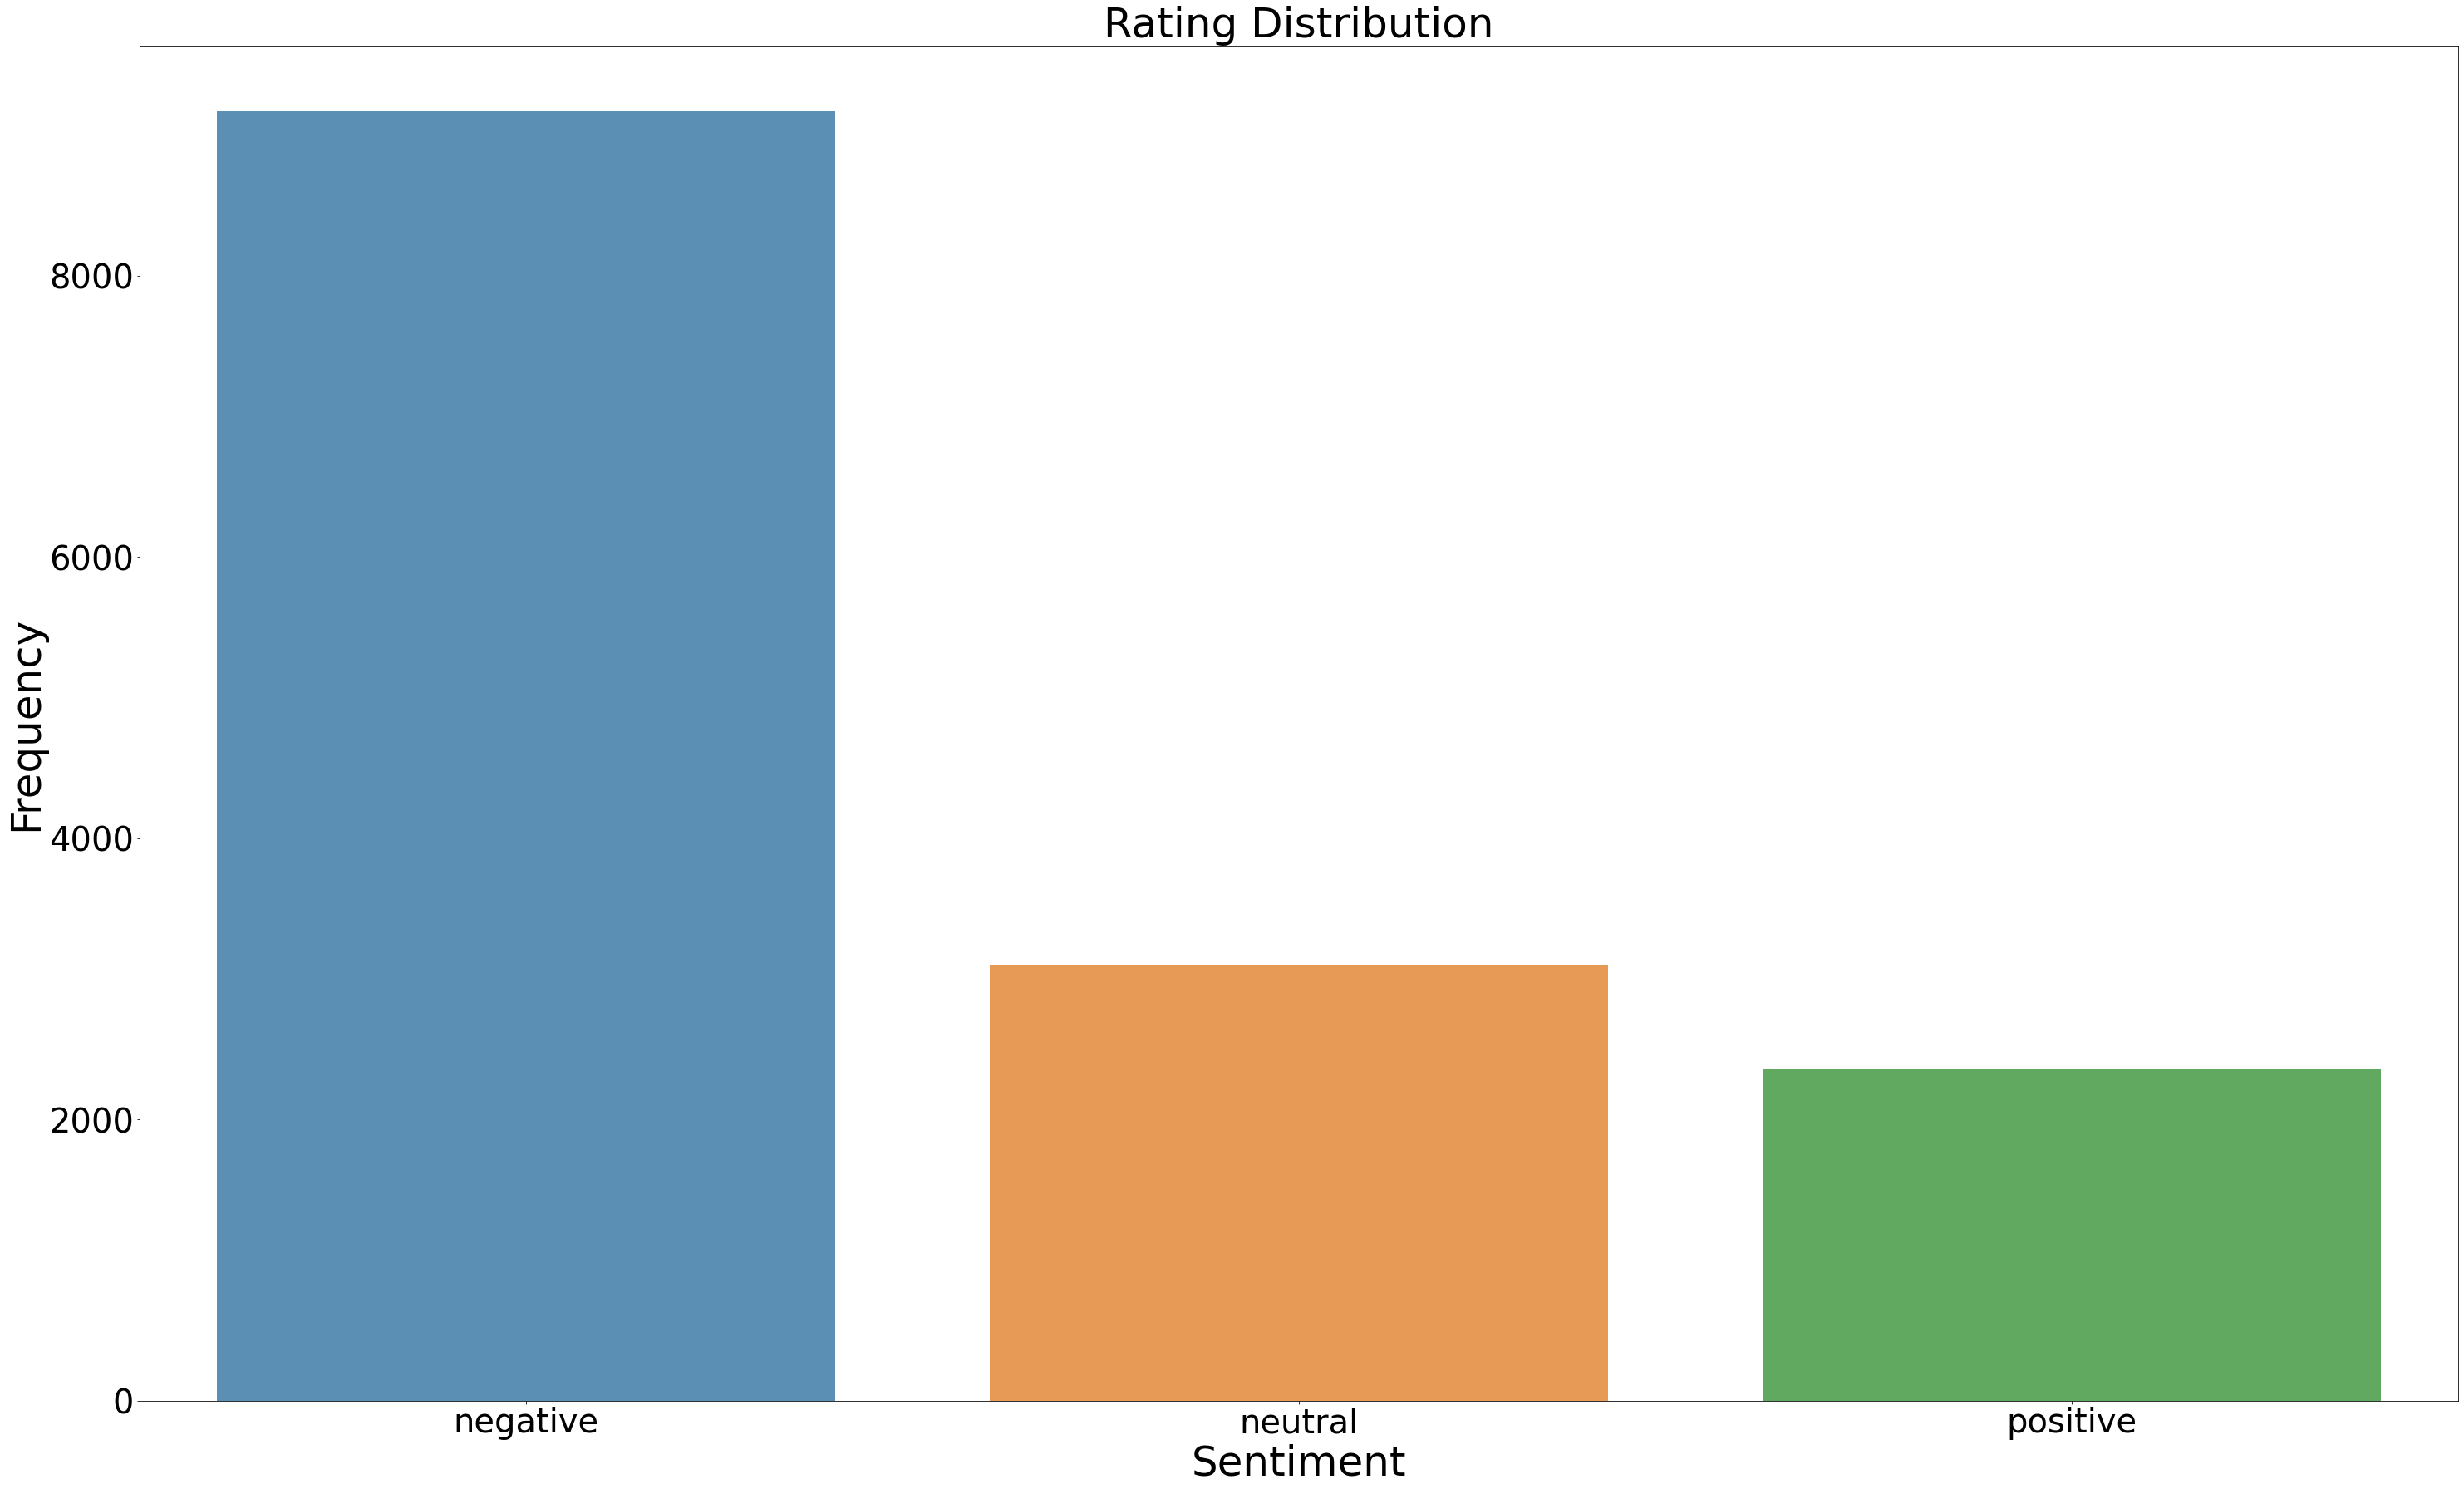

In [24]:
x_score = df.airline_sentiment.value_counts()
y_score = x_score.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_score.index, x_score.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)

In [25]:
# Widzimy że w naszej bazie danych większość tweetow jest zdecydowanie negatywna

<AxesSubplot:title={'center':'Percentage of Score'}, ylabel='airline_sentiment'>

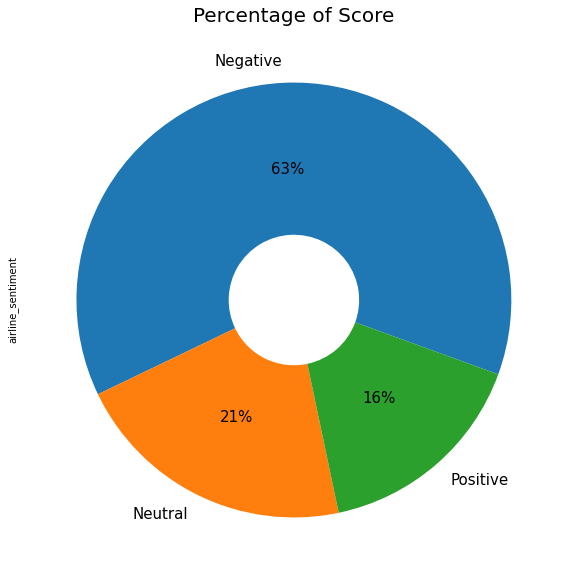

In [26]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Score', fontsize=20)
df.airline_sentiment.value_counts().plot(kind='pie', labels=['Negative', 'Neutral', 'Positive'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

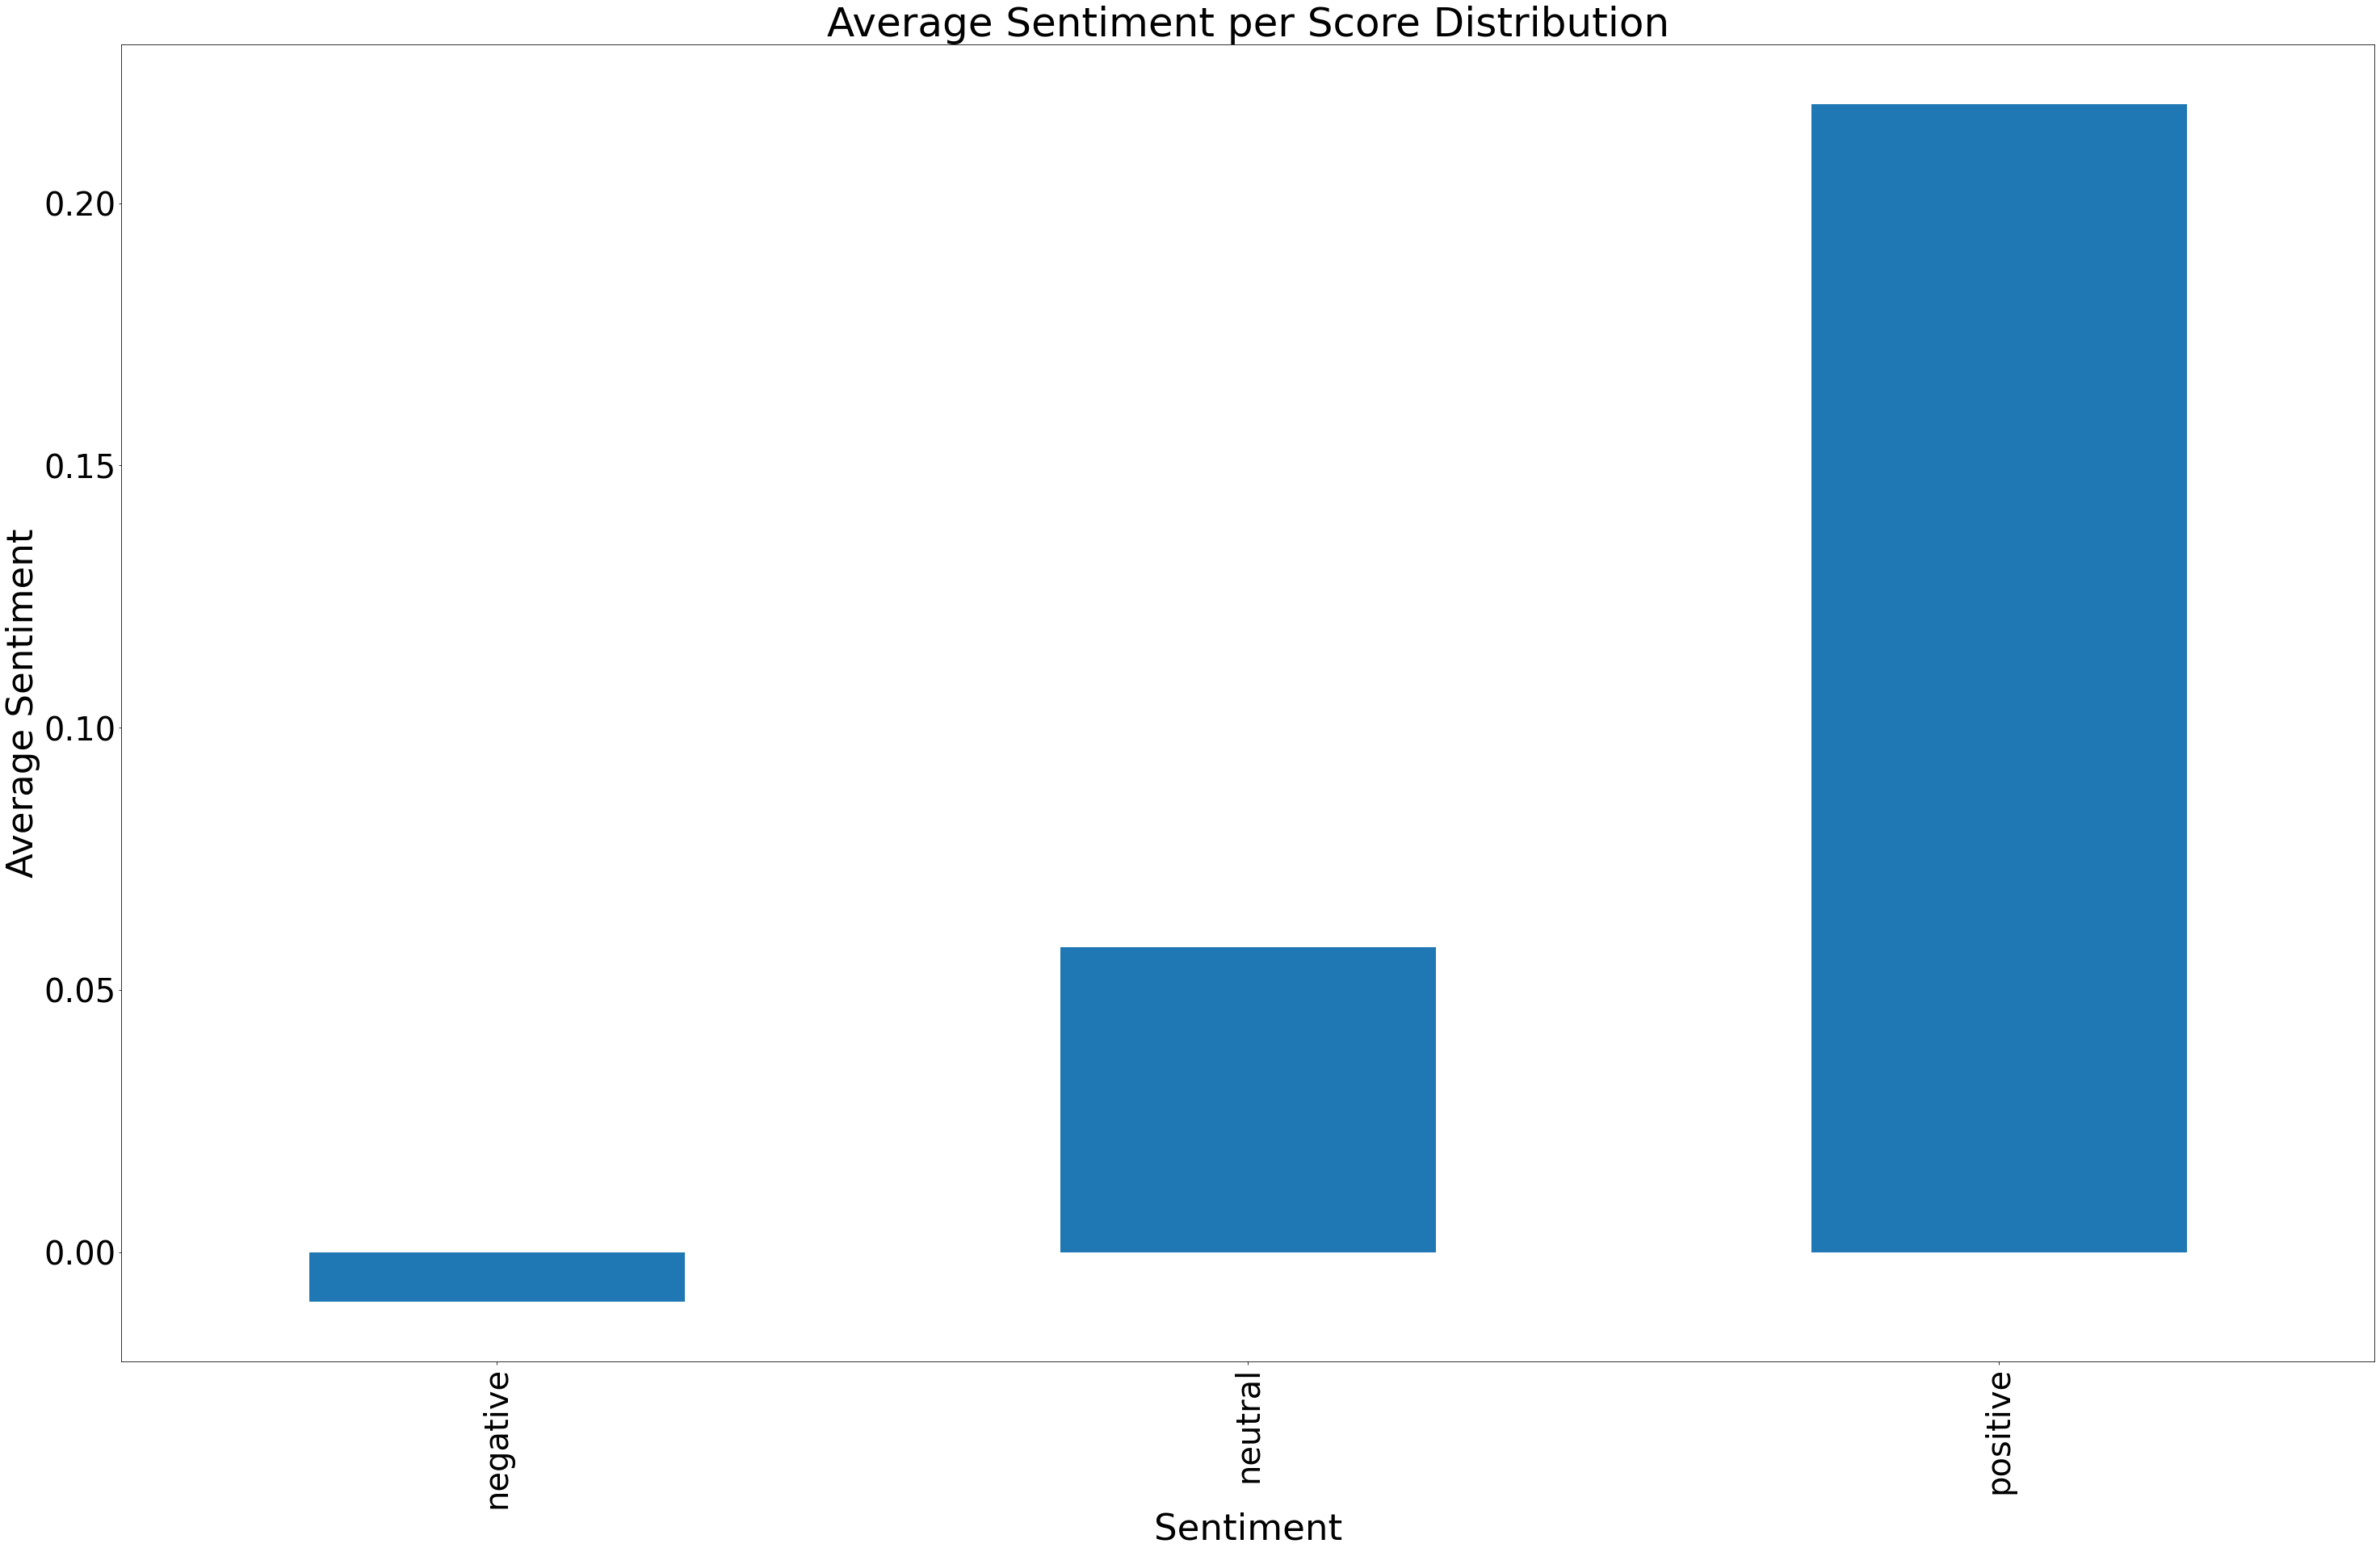

In [27]:
polarity_avg = df.groupby('airline_sentiment')['sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Sentiment', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Score Distribution', fontsize=50)
plt.show()

In [28]:
# Średnie rozłożenie wartości sentimentu ze względu na ocenę czyli negative, neutral i positive.
#  Jak możemy zauważyć większa średnia wartości sentimentu jest w pozytywnych tweetach.

In [29]:
# Chmura słów

In [30]:
words = df['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist

print(allwords)

['say', 'plus', 'ad', 'commerci', 'experi', 'tacki', 'today', 'must', 'mean', 'need', 'take', 'anoth', 'trip', 'realli', 'aggress', 'blast', 'obnoxi', 'entertain', 'guest', 'face', 'amp', 'littl', 'recours', 'realli', 'big', 'bad', 'thing', 'serious', 'would', 'pay', '', 'flight', 'seat', 'play', 'realli', 'bad', 'thing', 'fli', 'va', 'yes', 'near', 'everi', 'time', 'fli', 'vx', 'ear', 'worm', 'go', 'away', '', 'realli', 'miss', 'prime', 'opportun', 'men', 'without', 'hat', 'parodi', 'there', 'httpstcomwpg7grezp', 'well', 'notbut', 'do', 'd', 'amaz', 'arriv', 'hour', 'earli', 'good', 'me', 'know', 'suicid', 'second', 'lead', 'death', 'among', 'teen', '', 'lt', 'pretti', 'graphic', 'much', 'good', 'minim', 'iconographi', 'd', 'great', 'deal', 'alreadi', 'think', '2nd', 'trip', 'amp', 'even', 'go', '1st', 'trip', 'yet', 'p', 'fli', 'fabul', 'seduct', 'sky', 'again', 'take', 'stress', 'away', 'travel', 'httptcoahlxhhkiyn', 'thank', 'sfopdx', 'schedul', 'still', 'mia', 'excit', 'first', 'c

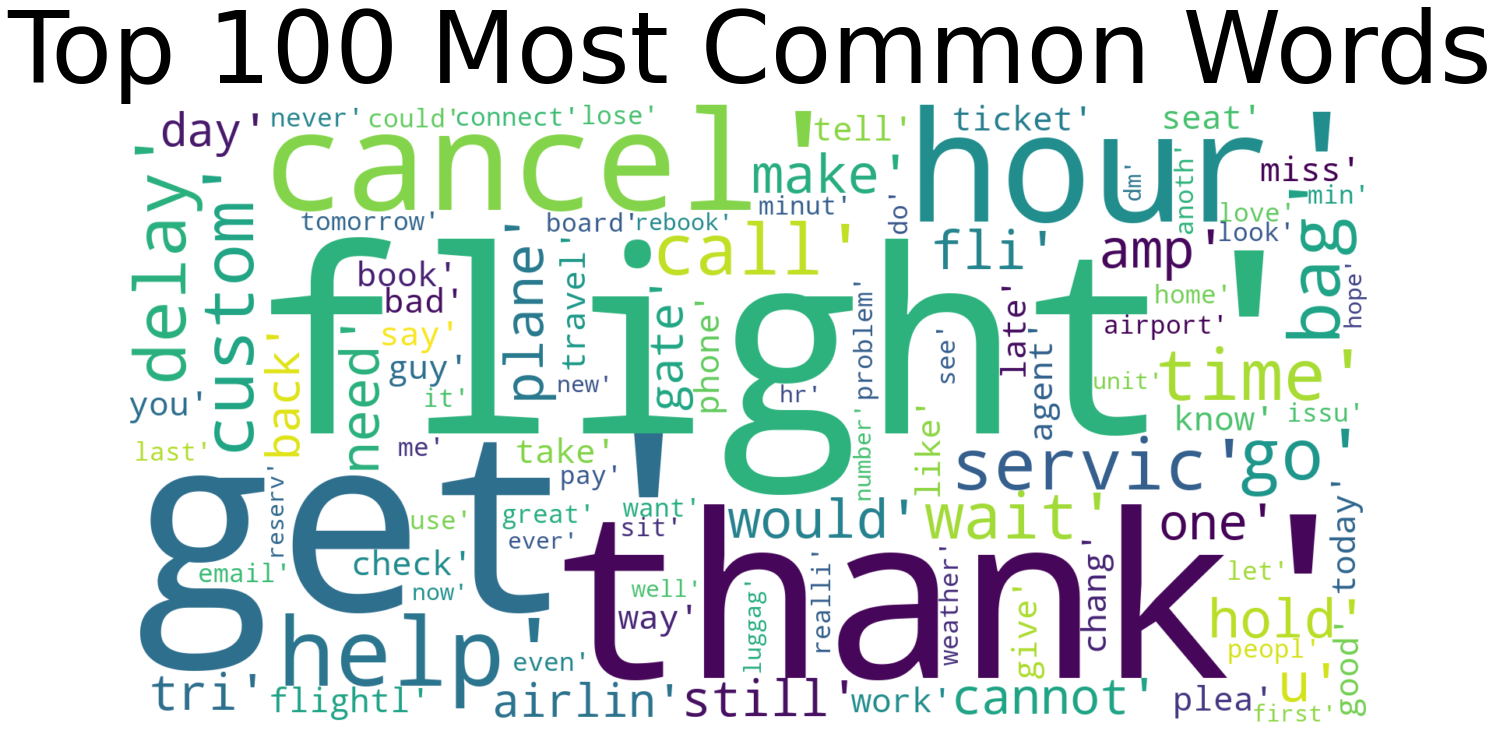

In [31]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

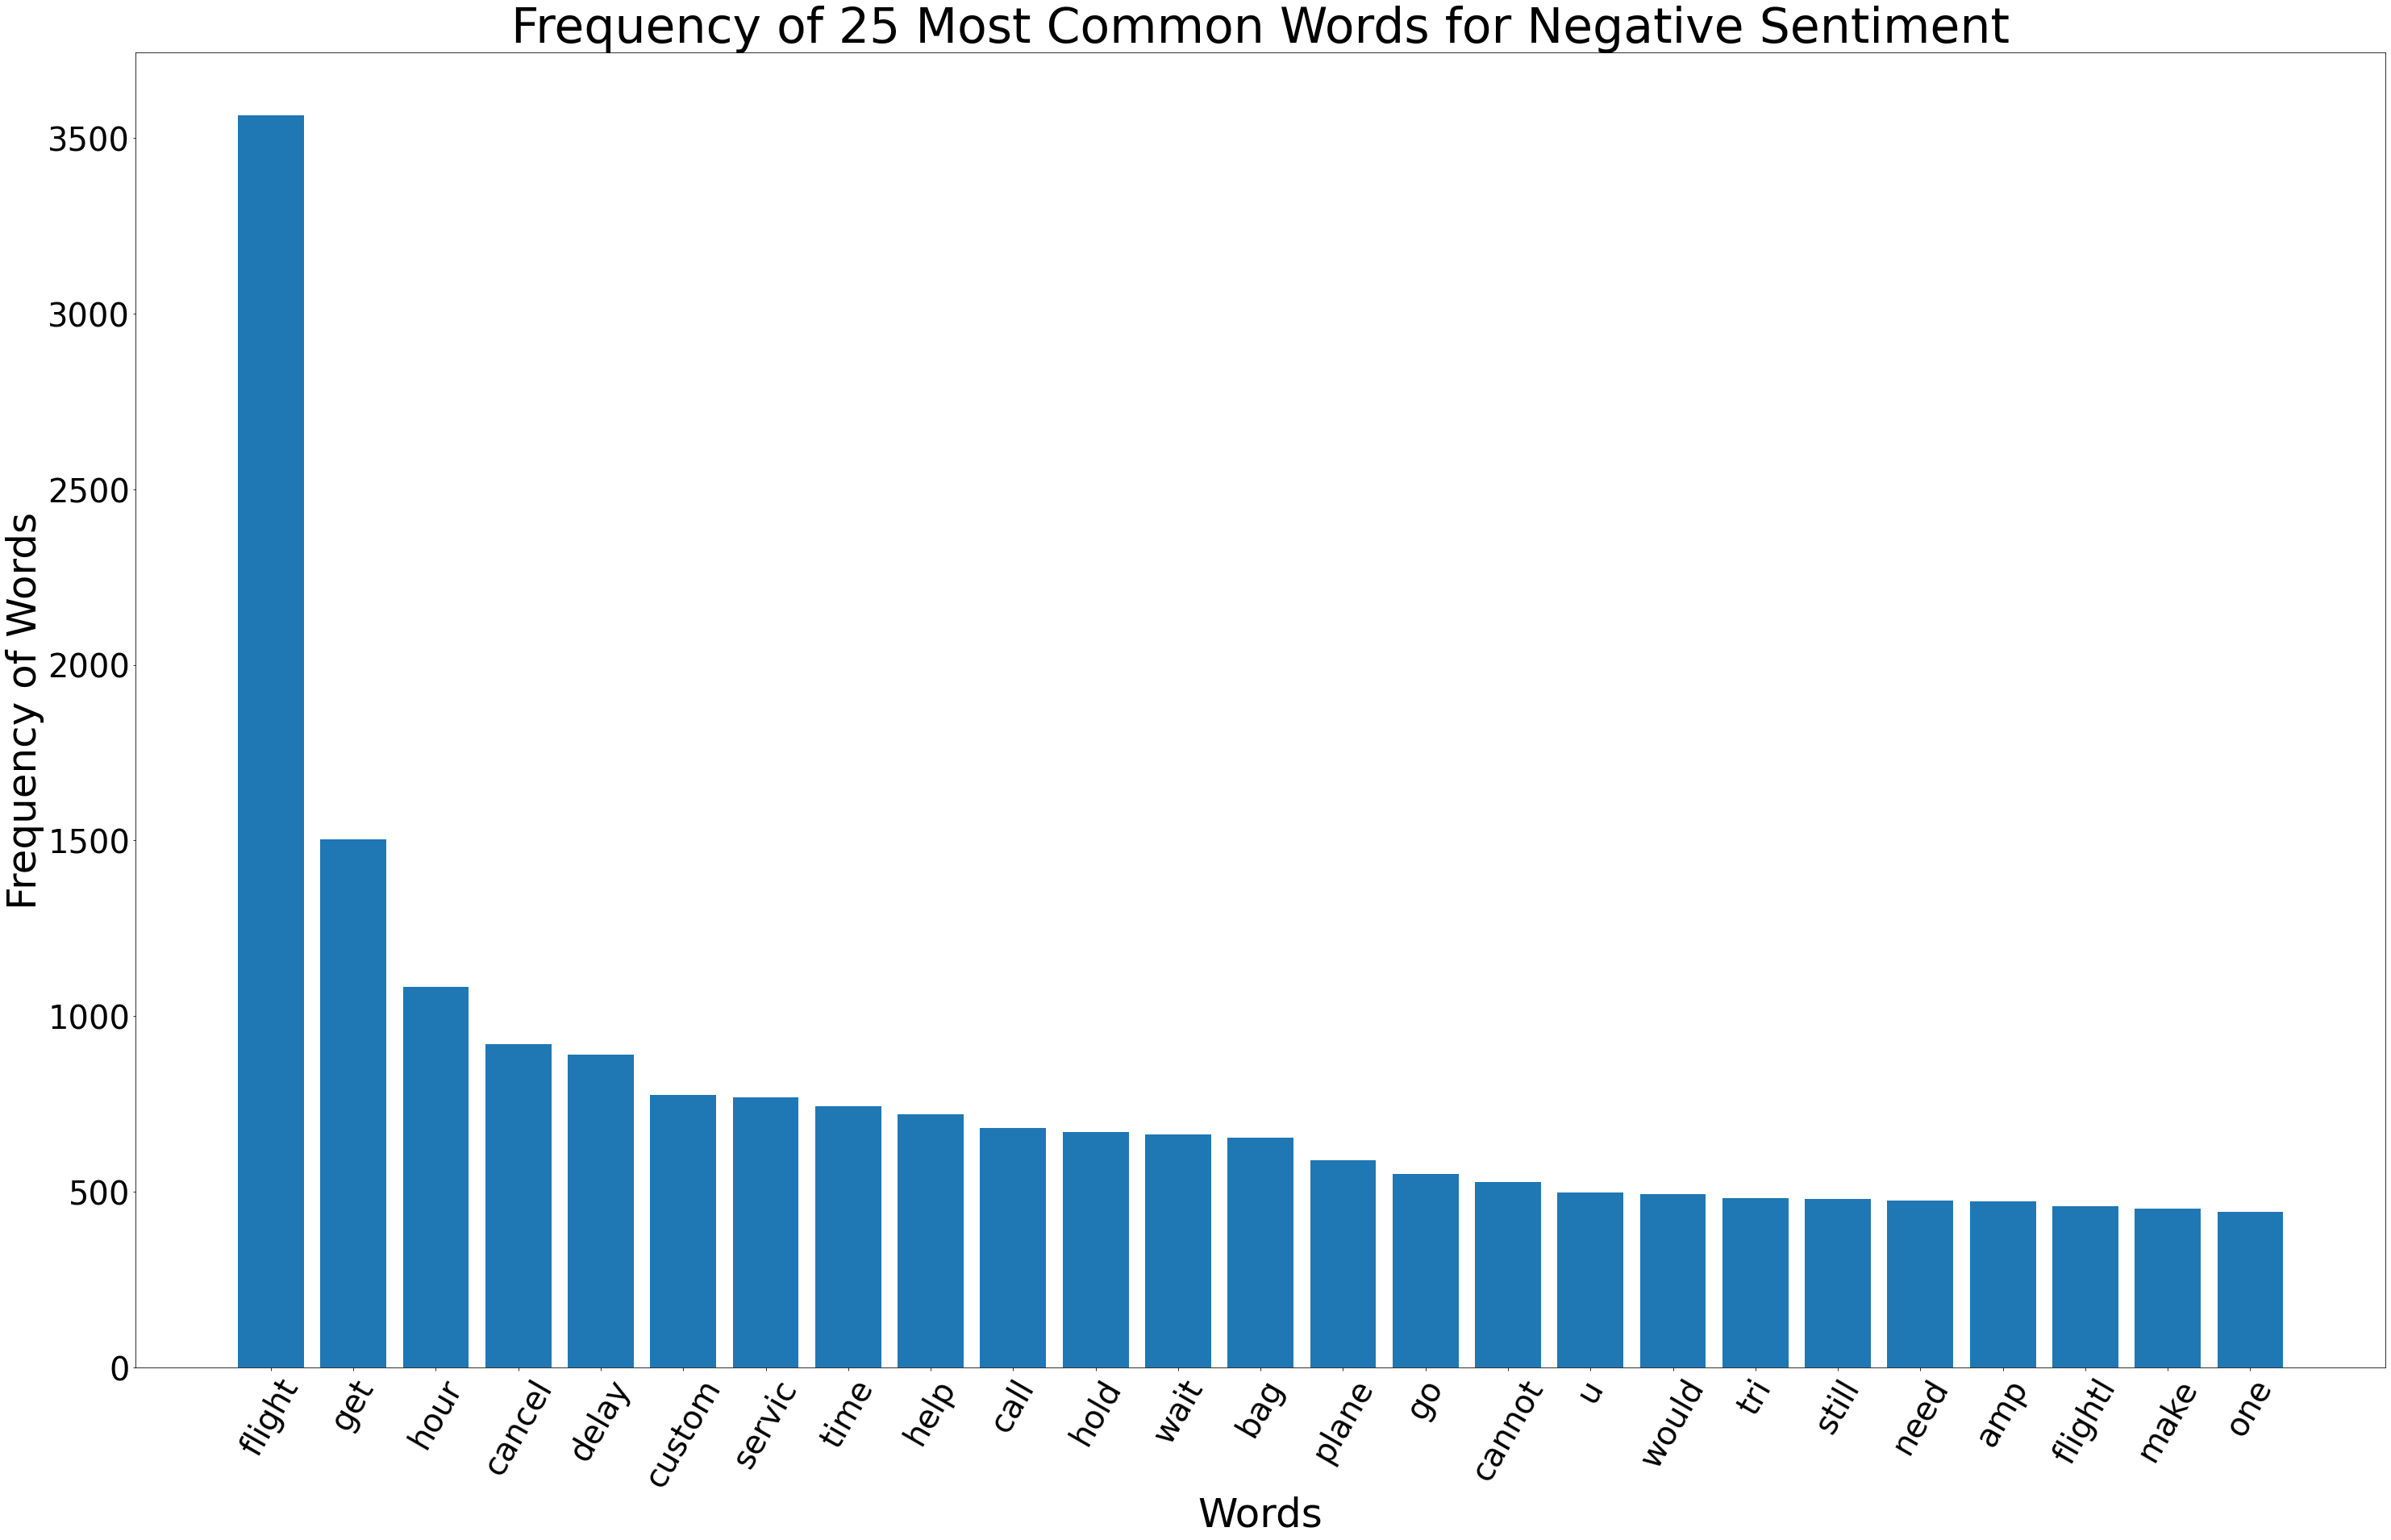

In [32]:
group_by = df.groupby('airline_sentiment')['lemma_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Negative Sentiment', fontsize=60)
plt.show()

In [33]:
# Najczęściej używanym słowem w sentimencie Negative jest słowo fligh w liczbie ponad 3500
# Następnie get okolo 1500
# i hour około 1000.

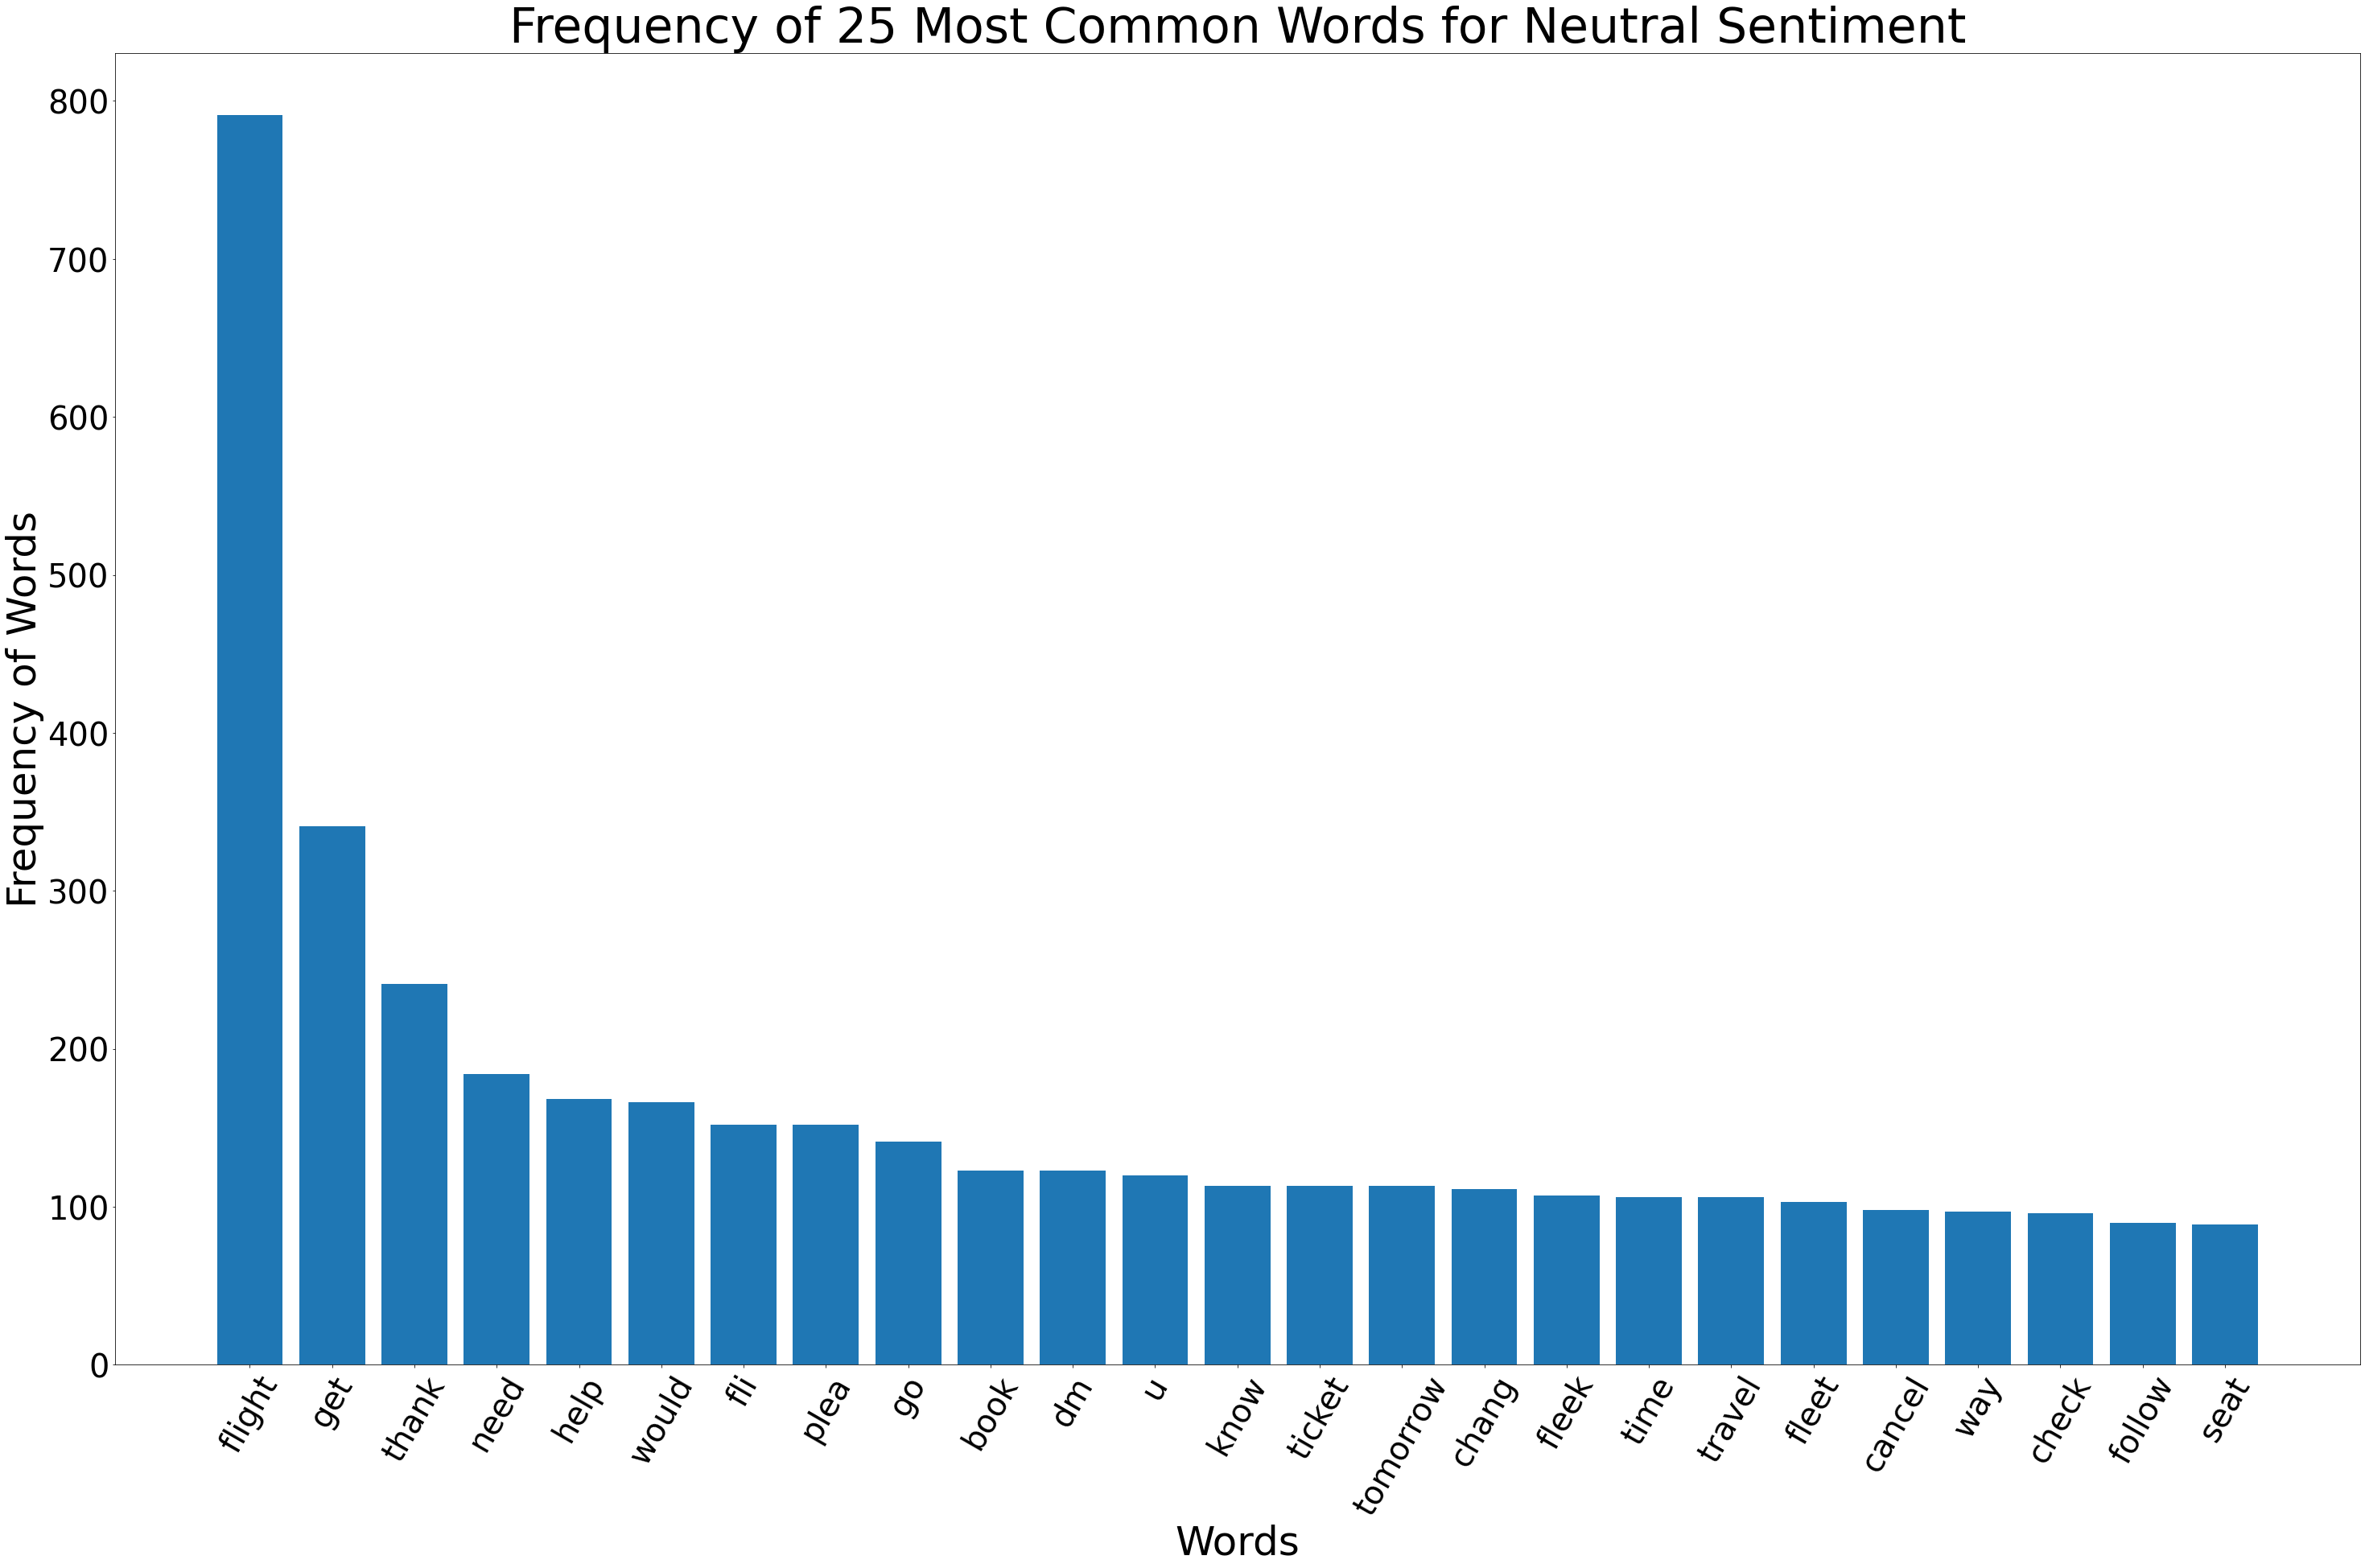

In [34]:
group_by_1 = group_by.iloc[1]
words1 = list(zip(*group_by_1))[0]
freq1 = list(zip(*group_by_1))[1]
plt.figure(figsize=(50,30))
plt.bar(words1, freq1)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Neutral Sentiment', fontsize=60)
plt.show()

In [35]:
# Najczęściej używanym słowem w sentimencie Negative jest słowo fligh w liczbie blisko 800
# Następnie get okolo 350
# i thank około 250.

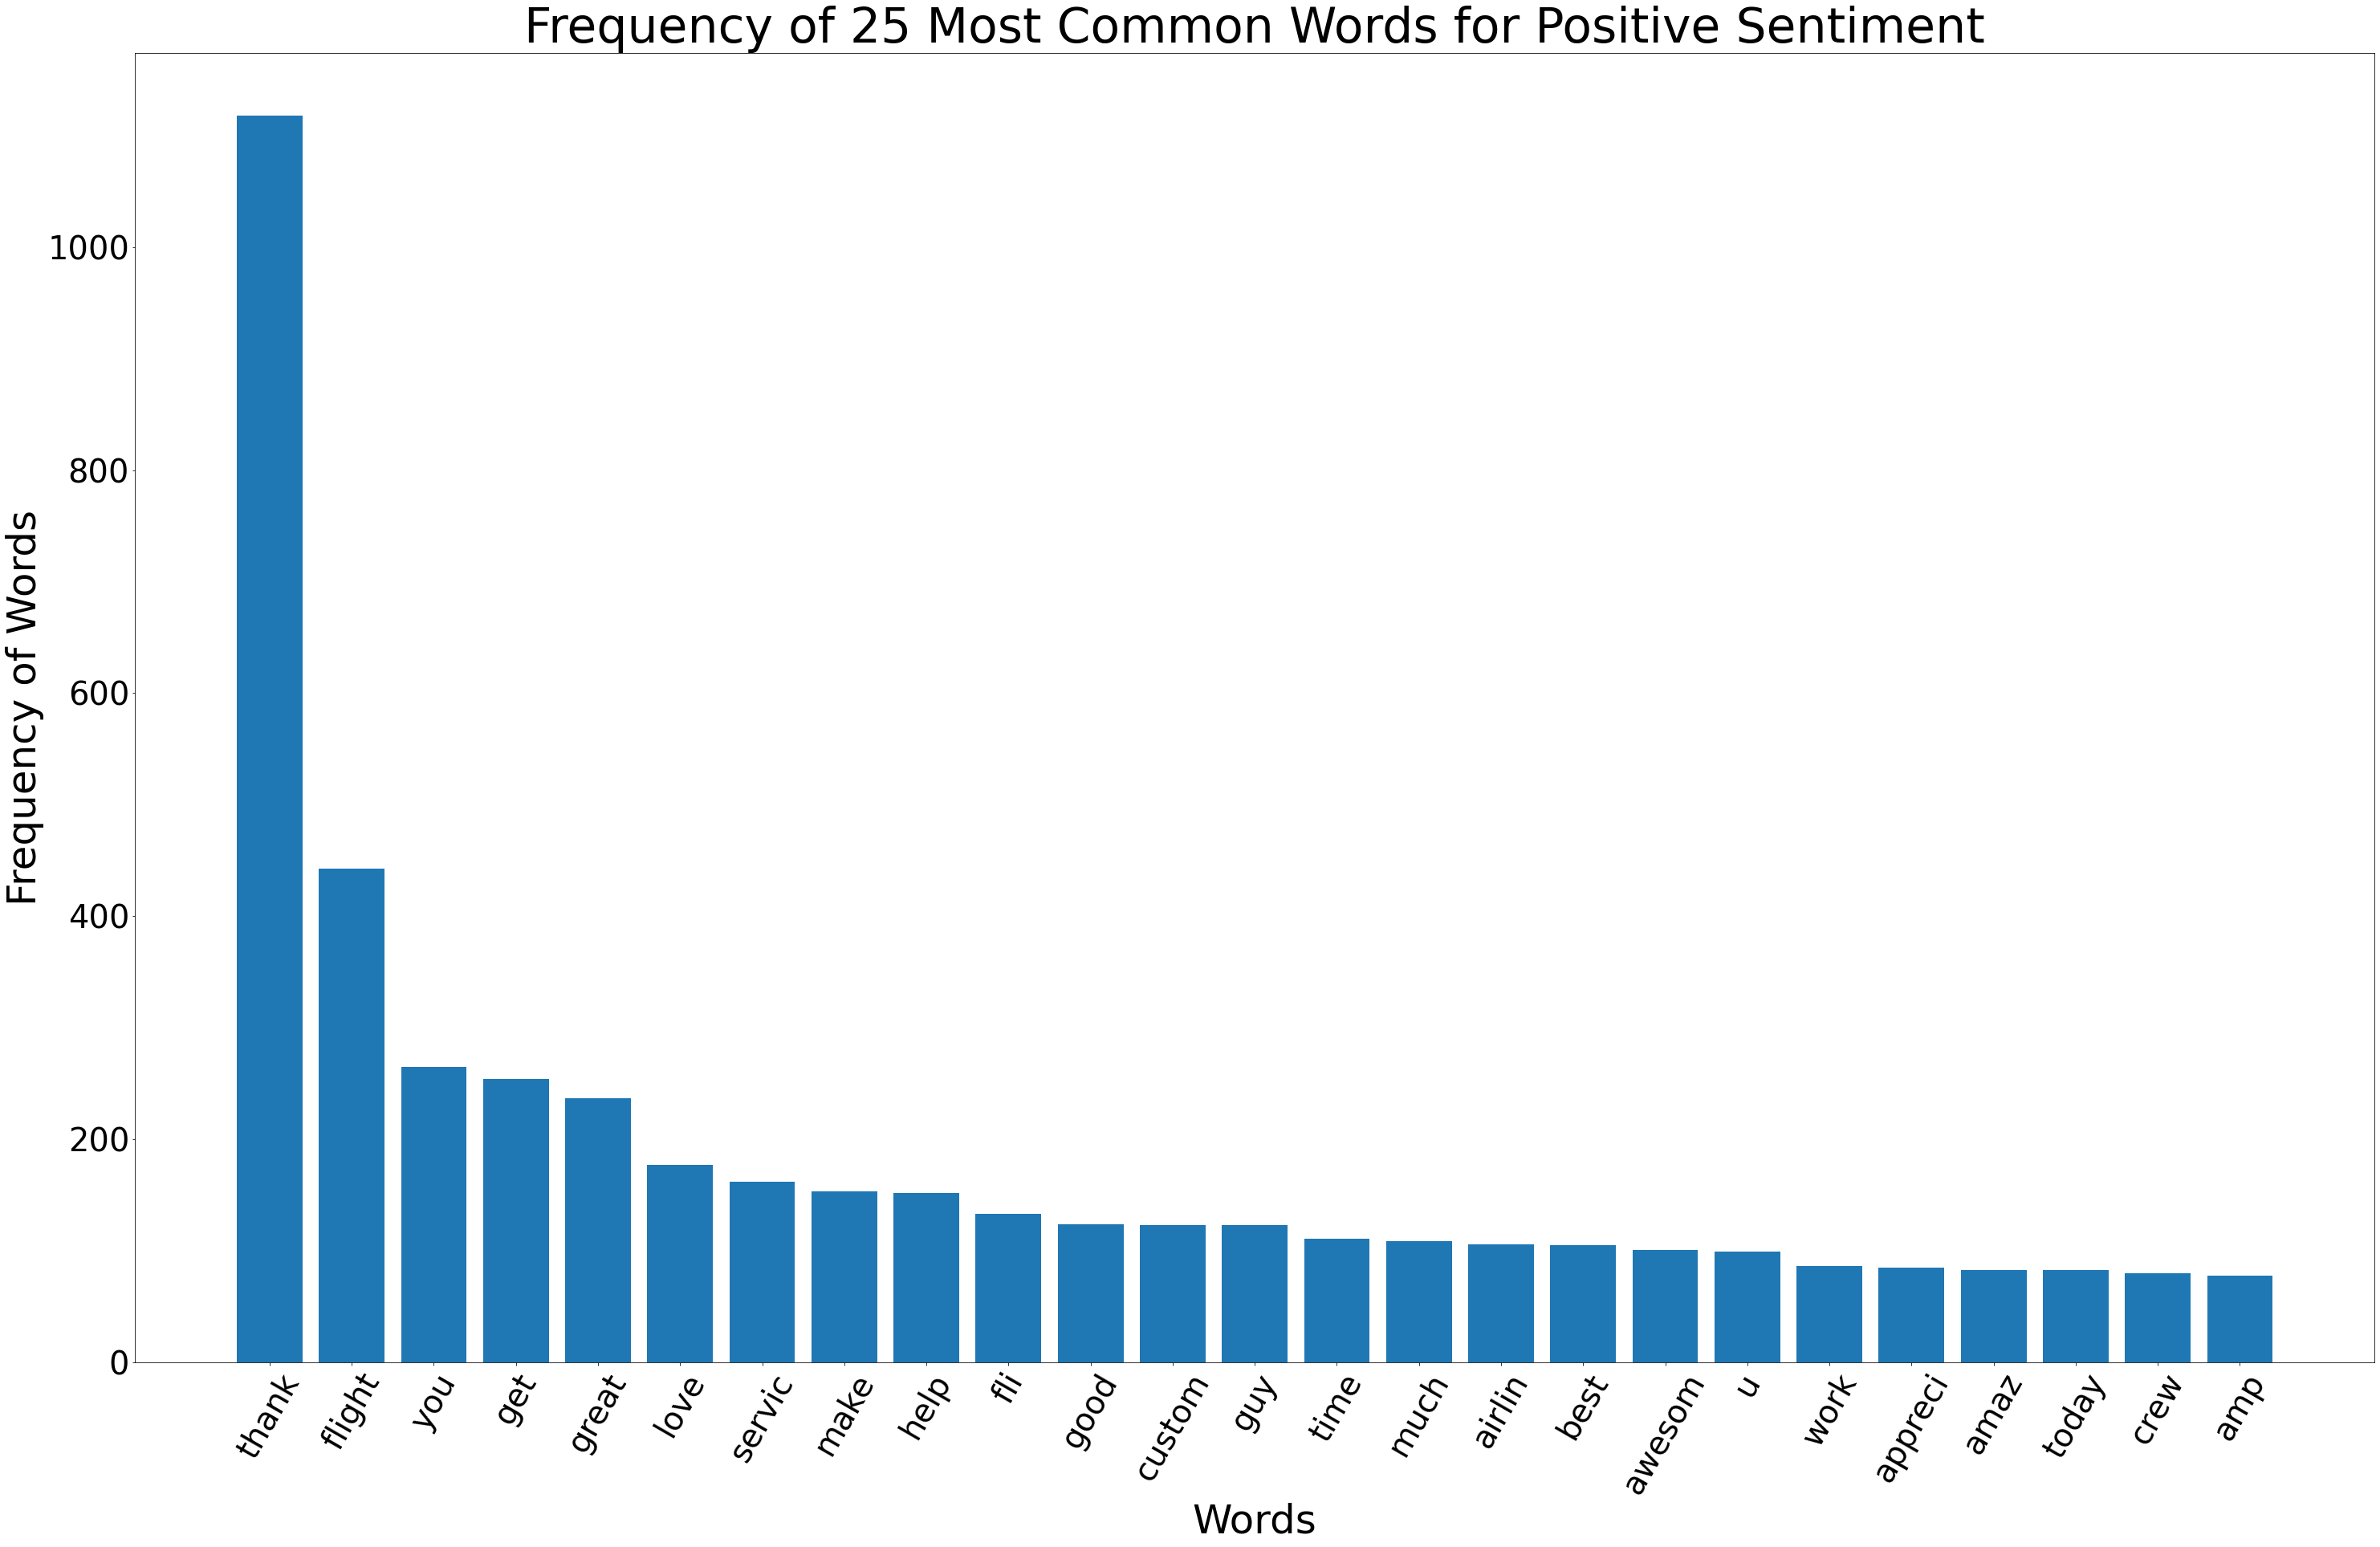

In [36]:
group_by_2 = group_by.iloc[2]
words2 = list(zip(*group_by_2))[0]
freq2 = list(zip(*group_by_2))[1]
plt.figure(figsize=(50,30))
plt.bar(words2, freq2)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Positive Sentiment', fontsize=60)
plt.show()

In [37]:
# Najczęściej używanym słowem w sentimencie Negative jest słowo thank w liczbie powyżej 1000
# Następnie fligh okolo 450
# i you około 230.

# Z powyższej chmury słów można się dowiedzieć że faktycznie przeważa liczba negatywnych tweetow w znacznej wiekszosci nad positive. 
# W pozytywnych tweetach więcej występuje słów takich jak love, great, thank, good
# W negatywnych tweetach występują słowa takie jak plane, wait, hour, delay - można więc stwierdzić że dużo osób skarży się na opóźnienia lotów przykładowo.

In [38]:
# Klasyfikatory

In [39]:
data = df_data
data.shape
data.head()

,airline_sentiment,lemma_str
0,neutral,say
1,positive,plus ad commerci experi tacki
2,neutral,today must mean need take anoth trip
3,negative,realli aggress blast obnoxi entertain guest fa...
4,negative,realli big bad thing


In [40]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data.lemma_str)
X_train_counts.shape

(14640, 11570)

In [41]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(14640, 11570)

In [42]:
clf = MultinomialNB().fit(X_train_tfidf, data.airline_sentiment)

In [43]:
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB()),])
text_clf = text_clf.fit(data.lemma_str, data.airline_sentiment)

In [44]:
data_test = data
predicted = text_clf.predict(data.lemma_str)
np.mean(predicted == data.airline_sentiment)
# Klasyfikator Bayesa

0.7354508196721311

In [45]:
# Bayesa jest precyzyjny na 73 %

In [46]:
text_clf_svm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf-svm', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3,random_state=42)),])
_ = text_clf_svm.fit(data.lemma_str, data.airline_sentiment)
predicted_svm = text_clf_svm.predict(data.lemma_str)
np.mean(predicted_svm == data.airline_sentiment)
# Klasyfikator SVM

0.7063524590163934

In [47]:
# SVM jest precyzyjny na 71 %